# Practical 2 : Generative and Discriminative Models


In this practical, we will compare the Naïve Bayes Classifier (NBC) and Logistic Regression on six
datasets. As part of the practical you should briefly read the following paper:



**On Discriminative vs. Generative classifiers: A comparison of logistic regression
and naive Bayes**  
*Andrew Y. Ng and Michael I. Jordan*  
Advances in Neural Information Processing Systems (NIPS) 2001.

The paper is available on OLAT. 

You should read the Introduction and the Experiments sections. The goal of this practical is
to qualitatively reproduce some of the experimental results in this paper. You are strongly
encouraged to read the rest of the paper, which is rather short and straightforward to read,
though some of you may want to skip the formal proofs.

## Naïve Bayes Classifier

You should implement a Naïve Bayes Classifier directly in python. To keep your code tidy,
we recommend implementing it as a class. Make sure that your classifier can handle binary, continuous and categorical features, and an arbitrary number of class labels. Suppose the data has 3
different features, the first being binary, the second being continuous and the third being categorical, and that there are
4 classes. Write an implementation that you can initialise as follows:

    nbc = NBC(feature_types=['b', 'r', 'c'], num_classes=4)

Along the lines of classifiers provided in sklearn, you want to implement two more functions,
**fit** and **predict**. 
Recall the joint distribution of a generative model: $p(\mathbf{x}, y \mid \theta, \pi) = p(y | \pi) \cdot p(\mathbf{x} \mid y, \theta)$.
The fit function is expected to estimate all the parameters ($\theta$ and $\pi$) of the NBC. The predict function is expected to compute the probabilities that the new input belongs to all classes and
then return the class that has the largest probability.

    nbc.fit(X_train, y_train)
    ypredicted = nbc.predict(X_test)
    test_accuracy = np.mean(ypredicted == ytest)

Here we import the libraries. 

In [52]:
%matplotlib inline
import pylab
pylab.rcParams['figure.figsize'] = (10., 10.)

import scipy.stats as ss
import pandas as pd
import pickle as cp
import matplotlib.pyplot as plt
import numpy as np

Before implementing NBC, we suggest you first implement the three types of the distributions of the parameters of NBC. Your implementation should have two functions: **estimate** and **get_probability**. The estimate function takes some data as input and computes the maximum likelihood estimators (MLE) for the parameters $\theta$ of the distribution $p(x | \theta)$. The get_probability function takes a new input value $x_{new}$ and returns $p(x_{new} | \theta)$. For example, in the case of continuous features, we can use the Gaussian distribution. The estimate function will find the parameters $\mu$ and $\sigma$ for the Gaussian distribution with respect to the input data, and the function get_probability will return $\mathcal{N}(x_{new} \mid \mu, \sigma)$. 

![alt text](pics/mle_4.png)


You can import statistic libraries for the implementation of the distributions. We recommend using the statistical functions provided by `scipy.stats`. Read the documentation here: https://docs.scipy.org/doc/scipy/reference/stats.html


In [99]:
class ContFeatureParam:
    def estimate(self, X):
        # TODO: Estimate the parameters for the Gaussian distribution 
        # so that it best describes the input data X
        mean,var=norm.fit(X)
        self.mean=mean
        if var==0.0:
            self.var=0.000001
        else:
            self.var=var
   
    def get_probability(self, val):
        # TODO: returns the density value of the input value val
        # Note the input value val could be a vector rather than a single value
        prob_vec=norm.logpdf(val, loc=self.mean, scale=self.var) 
        
        return prob_vec
        

# Distribution for binary features
class BinFeatureParam:
    def estimate(self, X):
        # TODO: Estimate the parameters for the Bernoulli distribution 
        # so that it best describes the input data X
        # The code below is just for compilation. 
        # You need to replace it by your own code.
        p=0.0
        uniq=np.unique(X)
        if (uniq.size !=2):
            print("Error:Feature is not Binary !")
        elif(1 not in uniq and 0 not in uniq):
            print("Error:Feature values are other than 0 and 1")
        else:
            p=np.sum(X==1)/X.size
        
        self.p=p
    

    def get_probability(self, val):
        # TODO: returns the density value of the input value val
        # The code below is just for compilation. 
        # You need to replace it by your own code.
        rv = bernoulli(self.p)
        prob_vec= rv.pmf(val)
        
        return prob_vec
        

# Distribution for categorical features
class CatFeatureParam:
    def estimate(self, X):
        # TODO: Estimate the parameters for the Multinoulli distribution 
        # so that it best describes the input data X
        # The code below is just for compilation. 
        # You need to replace it by your own code.
        unique, counts = np.unique(X, return_counts=True)
        self.p_vect=counts/np.sum(counts)
        self.category=unique

    def get_probability(self, val):
        # TODO: returns the density value of the input value val
        # The code below is just for compilation. 
        # You need to replace it by your own code.
        count_cat=[]
        for i in self.category:
            count_cat.append(np.sum(val==i))
        prob_vec=multinomial.logpmf(count_cat, n=val.size, p=self.p_vec)

        return prob_vec
    
    

Let us now implement a class for NBC. We'll keep it simple and try to follow the sklearn models. We'll have an init function, fit function and predict function.

**Hints for function fit**: Recall the joint distribution of a generative model: $p(\mathbf{x}, y \mid \theta, \pi) = p(y | \pi) \cdot p(\mathbf{x} \mid y, \theta)$. 
The fit function will estimate the parameters for NBC based on the training data. 
Here we give you some hints how to estimate the $\theta$ in $p(\mathbf{x} \mid y, \theta)$. 

For each class $c$, we want to estimate the $\theta_c$ for the distribution $p(\mathbf{x} \mid y = c, \theta_c)$. 
Since the assumption of NBC that the features are conditionally independent given the class $c$, the class conditional distribution is a product of $D$ distributions, one for each feature: $p(\mathbf{x} \mid y = c, \theta_c) = \prod_{j}^{D} p(x_j \mid y = c, \theta_{jc})$. Hence, we need to estimate the $\theta_{jc}$ based on the data with class $c$ and feature $j$. 

![alt text](pics/fit_4.png)


**Hints for function predict**: The predict function should compute the probabilities $p(y = c \mid \mathbf{x}_{new}, \pi, \theta)$ for the new inputs $\mathbf{x}_{new}$ on all classes by applying the Bayes rule:

$$p(y = c \mid \mathbf{x}_{new}, \pi, \theta) = \frac{p(y = c \mid \pi_c) \cdot p(\mathbf{x}_{new} \mid y=c, \theta)}{\sum^{C}_{c'=1}p(y=c' \mid \pi_{c'}) \cdot p(\mathbf{x}_{new} \mid y=c', \theta_{c'})},$$

and then return the class that has the largest probability:

$$y_{predict} = \underset{c}{arg\,\max} \, {p(y = c \mid \mathbf{x}_{new}, \theta_c)}.$$

Here we give you some hints on the computation of $p(\mathbf{x}_{new} \mid y=c, \theta_c)$. 
Due to the conditional independence assumption, we have $p(\mathbf{x}_{new} \mid y=c, \theta_c) = \prod_{j}^{D} p(x^j_{new} \mid y = c, \theta_{jc})$. Since we have got the parameters $\theta_{jc}$ in the fit phase,  we can use them to compute the probabilities for the new data. 

![alt text](pics/predict_3.png)

In [100]:
class NBC:
    # Inputs:
    #   feature_types: the array of the types of the features, e.g., feature_types=['r', 'r', 'r', 'r']
    #   num_classes: number of classes of labels
    def __init__(self, feature_types=[], num_classes=0):
        ''' Initialization: Store distribution object for each feature and class 
            into  list "self.X_rv_all_class" 
            "self.X_dist_all_class": list of distribution using distribution class object
                size= num_classes * num_features
                First index gives class
                Second index gives feature
            
        '''
        #list of list where each inside list contain rv for each class label (Class*features)
        self.X_dist_all_class=[]
        for clas in range(num_classes):
            X_dist_per_class=[]
            for feat_type in feature_types:
                if feat_type=='r':
                    rv=ContFeatureParam()
                elif feat_type=='b':
                    rv=BinFeatureParam()
                elif feat_type=='c':
                    rv=CatFeatureParam()
                else:
                    print("Error:Unkown Feature type Detected")
                    raise
                X_dist_per_class.append(rv)
        
            self.X_dist_all_class.append(X_dist_per_class)
            
        self.num_classes=num_classes
        
        self.y_dist=np.zeros(num_classes)
        
    
    # The function uses the input data to estimate all the parameters of the NBC
    # You should use the parameters based on the types of the features
    def fit(self, X, y):
        ''' Function: Calculates 𝜃𝑗𝑐 for each class and column by calling estimate method
            of all rv objects intialized in __init__
        '''
        
        for clas in range(self.num_classes):
            idx= np.where(y == clas)
            X_given_c=X[idx]
            
            for feat_idx in range(X.shape[1]):
                
                X_feat_given_c=X_given_c[:,feat_idx]
                
                self.X_dist_all_class[clas][feat_idx].estimate(X_feat_given_c)

            self.y_dist[clas]=np.sum(y==clas)/y.size   
        
        
    # The function takes the data X as input, and predicts the class for the data
    def predict(self, X):
        
        prob_y_posterior=np.zeros((self.num_classes,X.shape[0]))
        # print(prob_y_posterior.shape)

        for clas in range(self.num_classes):
            prob_y_c=np.zeros(X.shape[0])
            prob_X_c=np.zeros(X.shape[0])
            prob_y_c+= np.log(self.y_dist[clas])
            
            for feat in range(X.shape[1]):
                prob_feat_c= self.X_dist_all_class[clas][feat].get_probability(X[:,feat])
                
                prob_X_c+=prob_feat_c
        
            prob_y_posterior[clas]= prob_y_c + prob_X_c
            
        #normalizing 
        prob_y_posterior=prob_y_posterior
            
        pred_class=np.argmax(prob_y_posterior,axis=0)
        
        return pred_class
      

**Implementation Issues**
- Fell free to add auxiliary functions. 
- Don't forget to compute $p(y=c | \pi)$ 
- Remember to do all the calculations in log space to avoid running into underflow issues. Read more: (Mur) Chapter 3.5.3
- Your implementation should be able to handle missing values
- As far as possible use matrix operations. So assume that Xtrain, ytrain, Xtest will all
be numpy arrays. Try and minimise your use of python loops. (In general, looping over
classes or features is OK, but looping over data is probably not a good idea.)
- The variance parameter for Gaussian distributions should never be exactly 0, so in
case your calculated variance is 0, you may want to set it to a small value such as 1e − 6.
Note that this is essential to ensure that your code never encounters division by zero or
taking logarithms of 0 errors. Also, you want to ensure that the estimates for the parameter for the Bernoulli or Multinoulli random variables
is never exactly 0 or 1. For this reason you should consider using Laplace smoothing (https://en.wikipedia.org/wiki/Additive_smoothing).


You can use the below code to do sanity check of your implementation using the iris dataset. All features of the iris dataset are continuous, so you do not need to implement all types of feature parameters to check your code. 

You should expect your implementation has an accuracy larger than 90%. 

In [102]:
from sklearn.datasets import load_iris
iris = load_iris()
X, y = iris['data'], iris['target']

N, D = X.shape
Ntrain = int(0.8 * N)
shuffler = np.random.permutation(N)
Xtrain = X[shuffler[:Ntrain]]
ytrain = y[shuffler[:Ntrain]]
Xtest = X[shuffler[Ntrain:]]
ytest = y[shuffler[Ntrain:]]


nbc_iris = NBC(feature_types=['r', 'r', 'r', 'r'], num_classes=3)
nbc_iris.fit(Xtrain, ytrain)
yhat = nbc_iris.predict(Xtest)

test_accuracy = np.mean(yhat == ytest)
test_error = np.mean(yhat != ytest)

print("Accuracy:", test_accuracy)
X.shape
test_error

Accuracy: 0.9666666666666667


0.03333333333333333

## Logistic Regression

For logistic regression, you should use the implementation in sklearn. Adding the following
line will import the LR model.

    from sklearn.linear_model import LogisticRegression

Read the information provided on the following links to understand some details about how the
logistic regression model is implemented in scikit-learn.
- http://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
- http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression


## Comparing NBC and LR

### Experiments

You will compare the classification error of the NBC and LR trained on increasingly
larger training datasets. Because the datasets are so small, you should do this multiple times and
average the classification error. One run should look as follows:
- Shuffle the data, put 20% aside for testing.
    
    ```N, D = X.shape
    Ntrain = int(0.8 * N)
    shuffler = np.random.permutation(N)
    Xtrain = X[shuffler[:Ntrain]]
    ytrain = y[shuffler[:Ntrain]]
    Xtest = X[shuffler[Ntrain:]]
    ytest = y[shuffler[Ntrain:]]
    
    ```  


- Train the classifiers with increasingly more data. For example, we can train classifiers with 10%, 20%, ..., 100% of the training data. For each case store the classification errors on the test set of the classifiers.

You may want to repeat this with at least 200 random permutations (possibly as large as 1000)
to average out the test error across the runs. In the end, you will get average test errors as a
function of the size of the training data. Plot these curves for NBC and LR on the datasets.

In [103]:
from sklearn.linear_model import LogisticRegression
# inputs:
#   nbc: Naive Bayes Classifier
#   lr: Logistic Regression Classifier
#   X, y: data
#   num_runs: we need repeat num_runs times and store average results
#   num_splits: we want to compare the two models on increasingly larger training sets.
#               num_splits defines the number of increasing steps. 
# outputs:
#   the arrays of the test errors across the runs of the two classifiers 
def compareNBCvsLR(nbc, lr, X, y, num_runs=200, num_splits=10):
    # The code below is just for compilation. 
    # You need to replace it by your own code.
    ###################################################
    ##### YOUR CODE STARTS HERE #######################
    ###################################################
    tst_errs_nbc = np.zeros((num_splits))
    tst_errs_lr = np.zeros((num_splits))
    for run in range(num_runs):
        N, D = X.shape
        Ntrain = int(0.8 * N)
        shuffler = np.random.permutation(N)
        Xtrain = X[shuffler[:Ntrain]]
        ytrain = y[shuffler[:Ntrain]]
        Xtest = X[shuffler[Ntrain:]]
        ytest = y[shuffler[Ntrain:]]
        
        for split in range(num_splits):
            n, d = Xtrain.shape
            Ntrain = int(0.1*(split+1) * n)
            Xtrain_split=Xtrain[:Ntrain]
            ytrain_split=ytrain[:Ntrain]
            
            # NBC Classifier fit and predict
            nbc.fit(Xtrain_split, ytrain_split)
            yhat_nbc=nbc.predict(Xtest)
            
            # LR Classifier fit and predict
            lr.fit(Xtrain_split, ytrain_split)
            yhat_lr=lr.predict(Xtest)
            
            #Classification error
            tst_errs_nbc[split] += np.mean(yhat_nbc != ytest)
            tst_errs_lr[split] += np.mean(yhat_lr != ytest)
    
    tst_errs_nbc /=num_runs
    tst_errs_lr /=num_runs
    
    return tst_errs_nbc, tst_errs_lr
    ###################################################
    ##### YOUR CODE ENDS HERE #########################
    ###################################################

The utility function below defines the function for plotting. 

In [104]:
def makePlot(nbc_perf, lr_perf, title=None):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)

    ax.tick_params(axis='both', labelsize=20)

    ax.set_xlabel('Percent of training data used', fontsize=20)
    ax.set_ylabel('Classification Error', fontsize=20)
    if title is not None: ax.set_title(title, fontsize=25)

    xaxis_scale = [(i + 1) * 10 for i in range(10)]
    plt.plot(xaxis_scale, nbc_perf, label='Naive Bayes')
    plt.plot(xaxis_scale, lr_perf, label='Logistic Regression', linestyle='dashed')
    
    ax.legend(loc='upper right', fontsize=20)

### Datasets

Tasks: For each dataset,
1. prepare the data for the two classifiers
2. compare the two classifiers on the dataset and generate the plots
3. write a short report of how you prepare the data and your observations of the comparison 

**Dataset 1: Iris Dataset**

https://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  150 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non-null    float64
 4   species            150 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 12.0 KB
3


/Users/ankushpanwar/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:354: RuntimeWarning: Mean of empty slice.
  loc = data.mean()
/Users/ankushpanwar/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/ankushpanwar/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:359: RuntimeWarning: Mean of empty slice.
  scale = np.sqrt(((data - loc)**2).mean())
<ipython-input-100-139a60d8cc78>:66: RuntimeWarning: divide by zero encountered in log
  prob_y_c+= np.log(self.y_dist[clas])
/Users/ankushpanwar/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:354: RuntimeWarning: Mean of empty slice.
  loc = data.mean()
/Users/ankushpanwar/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/U

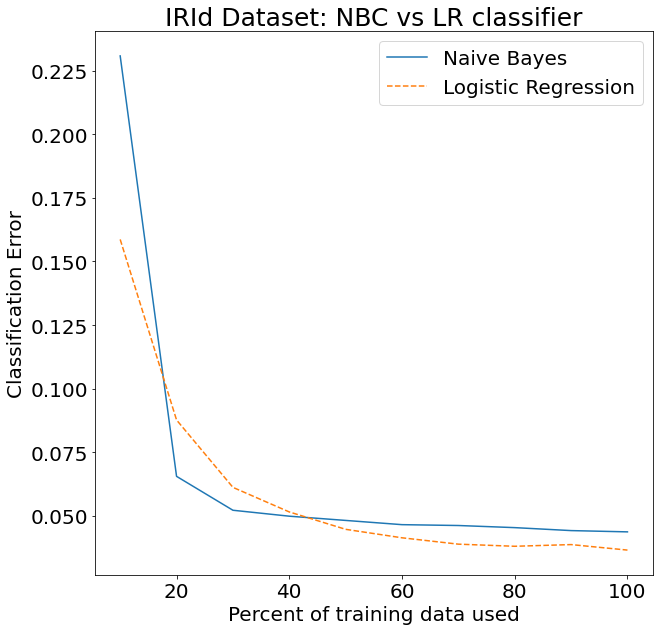

In [106]:
# TODO: insert your code for experiments
###################################################
##### YOUR CODE STARTS HERE #######################
###################################################
from sklearn.datasets import load_iris
iris_obj = load_iris()
# the code transform the iris dataset to a dataframe
iris = pd.DataFrame(iris_obj.data, columns=iris_obj.feature_names,index=pd.Index([i for i in range(iris_obj.data.shape[0])])).join(pd.DataFrame(iris_obj.target, columns=pd.Index(["species"]), index=pd.Index([i for i in range(iris_obj.target.shape[0])])))
iris.info()

X= iris.iloc[:,:4].to_numpy()
y= iris.iloc[:,4].to_numpy()

classes= np.unique(y)
print(classes.size)
#classifier initializations
nbc_iris = NBC(feature_types=['r', 'r', 'r', 'r'], num_classes=classes.size)
lr_iris=LogisticRegression(max_iter=1000)

tst_errs_nbc, tst_errs_lr=compareNBCvsLR(nbc_iris, lr_iris, X, y, num_runs=200, num_splits=10)

makePlot(tst_errs_nbc, tst_errs_lr, title="IRIS Dataset: NBC vs LR classifier")


**Dataset 2: Voting Dataset**

https://archive.ics.uci.edu/ml/datasets/congressional+voting+records


In [108]:
# TODO: insert your code for experiments
###################################################
##### YOUR CODE STARTS HERE #######################
###################################################
voting = pd.read_csv('../Data/voting.csv')
voting.info()

voting
###################################################
##### YOUR CODE ENDS HERE #########################
###################################################

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 435 entries, 0 to 434
Data columns (total 17 columns):
 #   Column                                  Non-Null Count  Dtype 
---  ------                                  --------------  ----- 
 0   label                                   435 non-null    object
 1   handicapped-infants                     423 non-null    object
 2   water-project-cost-sharing              387 non-null    object
 3   adoption-of-the-budget-resolution       424 non-null    object
 4   physician-fee-freeze                    424 non-null    object
 5   el-salvador-aid                         420 non-null    object
 6   religious-groups-in-schools             424 non-null    object
 7   anti-satellite-test-ban                 421 non-null    object
 8   aid-to-nicaraguan-contras               420 non-null    object
 9   mx-missile                              413 non-null    object
 10  immigration                             428 non-null    object
 11  synfue

,label,handicapped-infants,water-project-cost-sharing,adoption-of-the-budget-resolution,physician-fee-freeze,el-salvador-aid,religious-groups-in-schools,anti-satellite-test-ban,aid-to-nicaraguan-contras,mx-missile,immigration,synfuels-corporation-cutback,education-spending,superfund-right-to-sue,crime,duty-free-exports,export-administration-act-south-africa
0,republican,n,y,n,y,y,y,n,n,n,y,NaN,y,y,y,n,y
1,republican,n,y,n,y,y,y,n,n,n,n,n,y,y,y,n,NaN
2,democrat,NaN,y,y,NaN,y,y,n,n,n,n,y,n,y,y,n,n
3,democrat,n,y,y,n,NaN,y,n,n,n,n,y,n,y,n,n,y
4,democrat,y,y,y,n,y,y,n,n,n,n,y,NaN,y,y,y,y
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
430,republican,n,n,y,y,y,y,n,n,y,y,n,y,y,y,n,y
431,democrat,n,n,y,n,n,n,y,y,y,y,n,n,n,n,n,y
432,republican,n,NaN,n,y,y,y,n,n,n,n,y,y,y,y,n,y
433,republican,n,n,n,y,y,y,NaN,NaN,NaN,NaN,n,y,y,y,n,y


**Dataset 3: Car Evaluation Dataset**

https://archive.ics.uci.edu/ml/datasets/car+evaluation

In [110]:
# TODO: insert your code for experiments
###################################################
##### YOUR CODE STARTS HERE #######################
###################################################
car = pd.read_csv('../Data/car.csv')
car.info()
car
###################################################
##### YOUR CODE ENDS HERE #########################
###################################################

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1728 entries, 0 to 1727
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   buying         1728 non-null   object
 1   maint          1728 non-null   object
 2   doors          1728 non-null   object
 3   persons        1728 non-null   object
 4   lug_boot       1728 non-null   object
 5   safety         1728 non-null   object
 6   acceptability  1728 non-null   object
dtypes: object(7)
memory usage: 94.6+ KB


,buying,maint,doors,persons,lug_boot,safety,acceptability
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc
...,...,...,...,...,...,...,...
1723,low,low,5more,more,med,med,good
1724,low,low,5more,more,med,high,vgood
1725,low,low,5more,more,big,low,unacc
1726,low,low,5more,more,big,med,good


**Dataset 4: Breast Cancer Dataset**

https://archive.ics.uci.edu/ml/datasets/breast+cancer

In [111]:
# TODO: insert your code for experiments
###################################################
##### YOUR CODE STARTS HERE #######################
###################################################
cancer = pd.read_csv('../Data/breast-cancer.csv')
cancer.info()
cancer
###################################################
##### YOUR CODE ENDS HERE #########################
###################################################

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286 entries, 0 to 285
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Class        286 non-null    object
 1   age          286 non-null    object
 2   menopause    286 non-null    object
 3   tumor-size   286 non-null    object
 4   inv-nodes    286 non-null    object
 5   node-caps    286 non-null    object
 6   deg-malig    286 non-null    int64 
 7   breast       286 non-null    object
 8   breast-quad  286 non-null    object
 9   irradiat     286 non-null    object
dtypes: int64(1), object(9)
memory usage: 22.5+ KB


,Class,age,menopause,tumor-size,inv-nodes,node-caps,deg-malig,breast,breast-quad,irradiat
0,no-recurrence-events,30-39,premeno,30-34,0-2,no,3,left,left_low,no
1,no-recurrence-events,40-49,premeno,20-24,0-2,no,2,right,right_up,no
2,no-recurrence-events,40-49,premeno,20-24,0-2,no,2,left,left_low,no
3,no-recurrence-events,60-69,ge40,15-19,0-2,no,2,right,left_up,no
4,no-recurrence-events,40-49,premeno,0-4,0-2,no,2,right,right_low,no
...,...,...,...,...,...,...,...,...,...,...
281,recurrence-events,30-39,premeno,30-34,0-2,no,2,left,left_up,no
282,recurrence-events,30-39,premeno,20-24,0-2,no,3,left,left_up,yes
283,recurrence-events,60-69,ge40,20-24,0-2,no,1,right,left_up,no
284,recurrence-events,40-49,ge40,30-34,3-5,no,3,left,left_low,no


**Dataset 5: Ionosphere Dataset**

https://archive.ics.uci.edu/ml/datasets/ionosphere

In [3]:
# TODO: insert your code for experiments
###################################################
##### YOUR CODE STARTS HERE #######################
###################################################
ionosphere = pd.read_csv('./Data/ionosphere.csv')
ionosphere.info()
###################################################
##### YOUR CODE ENDS HERE #########################
###################################################

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 351 entries, 0 to 350
Data columns (total 35 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   feature1   351 non-null    int64  
 1   feature2   351 non-null    int64  
 2   feature3   351 non-null    float64
 3   feature4   351 non-null    float64
 4   feature5   351 non-null    float64
 5   feature6   351 non-null    float64
 6   feature7   351 non-null    float64
 7   feature8   351 non-null    float64
 8   feature9   351 non-null    float64
 9   feature10  351 non-null    float64
 10  feature11  351 non-null    float64
 11  feature12  351 non-null    float64
 12  feature13  351 non-null    float64
 13  feature14  351 non-null    float64
 14  feature15  351 non-null    float64
 15  feature16  351 non-null    float64
 16  feature17  351 non-null    float64
 17  feature18  351 non-null    float64
 18  feature19  351 non-null    float64
 19  feature20  351 non-null    float64
 20  feature21 

**Dataset 6: Sonar Dataset**

http://archive.ics.uci.edu/ml/datasets/connectionist+bench+%28sonar,+mines+vs.+rocks%29

In [6]:
# TODO: insert your code for experiments
###################################################
##### YOUR CODE STARTS HERE #######################
###################################################
sonar = pd.read_csv('./Data/sonar.csv')
sonar.info()
###################################################
##### YOUR CODE ENDS HERE #########################
###################################################

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 208 entries, 0 to 207
Data columns (total 61 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   feature1   208 non-null    float64
 1   feature2   208 non-null    float64
 2   feature3   208 non-null    float64
 3   feature4   208 non-null    float64
 4   feature5   208 non-null    float64
 5   feature6   208 non-null    float64
 6   feature7   208 non-null    float64
 7   feature8   208 non-null    float64
 8   feature9   208 non-null    float64
 9   feature10  208 non-null    float64
 10  feature11  208 non-null    float64
 11  feature12  208 non-null    float64
 12  feature13  208 non-null    float64
 13  feature14  208 non-null    float64
 14  feature15  208 non-null    float64
 15  feature16  208 non-null    float64
 16  feature17  208 non-null    float64
 17  feature18  208 non-null    float64
 18  feature19  208 non-null    float64
 19  feature20  208 non-null    float64
 20  feature21 